# README
This notebook is used to compute the alignment center for each sample. The alignment center is the average vector from all embeddings whose cycle life is ±$\alpha$ for the source sample.

In [2]:
import json
import numpy as np
from tqdm import tqdm
import pickle
import os
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import matplotlib
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [3]:
total_label_llm_out = np.load('outs/total_label_llm_out.npy')
total_labels = np.load('outs/total_labels.npy')
total_file_names = json.load(open('outs/total_file_names.json'))
total_indices = [i for i in range(len(total_label_llm_out))]
pretrained_model_path = './outs' # the path to the saved model checkpoints that produce these embeddings. In this notebook, the path will be used as the saving path to save the avg centers.

In [4]:
unique_labels, unique_indices = np.unique(total_labels, return_index=True)
unique_file_names = [total_file_names[i] for i in unique_indices]
unique_label_llm_out = total_label_llm_out[unique_indices]
unique_indices = np.arange(len(unique_label_llm_out))
print(len(unique_labels))
print(len(unique_file_names), unique_file_names)

388
388 ['MICH_03H_pouch_NMC_45C_0-100_0.2-0.2C.pkl', 'MICH_12H_pouch_NMC_45C_0-100_0.2-1.5C.pkl', 'Tongji1_CY25-05_1-#16.pkl', 'Tongji1_CY25-05_1-#12.pkl', 'XJTU_3C_battery-11.pkl', 'ISU-ILCC_G14C3.pkl', 'Tongji1_CY25-05_1-#2.pkl', 'Tongji1_CY25-05_1-#13.pkl', 'SNL_18650_NMC_15C_0-100_0.5-2C_b.pkl', 'Tongji1_CY25-05_1-#17.pkl', 'Tongji1_CY25-05_1-#5.pkl', 'SNL_18650_NMC_15C_0-100_0.5-2C_a.pkl', 'UL-PUR_N10-NA7_18650_NCA_23C_0-100_0.5-0.5C_g.pkl', 'Tongji1_CY25-05_1-#4.pkl', 'Tongji1_CY25-05_1-#14.pkl', 'Tongji1_CY25-05_1-#15.pkl', 'XJTU_3C_battery-15.pkl', 'MICH_04R_pouch_NMC_25C_0-100_1.5-1.5C.pkl', 'SNL_18650_NCA_25C_0-100_0.5-0.5C_b.pkl', 'Tongji1_CY45-05_1-#17.pkl', 'Tongji2_CY25-05_1-#12.pkl', 'Tongji1_CY45-05_1-#19.pkl', 'MICH_02C_pouch_NMC_-5C_0-100_0.2-0.2C.pkl', 'Tongji1_CY45-05_1-#15.pkl', 'Tongji1_CY25-025_1-#3.pkl', 'Tongji1_CY25-025_1-#5.pkl', 'HNEI_18650_NMC_LCO_25C_0-100_0.5-1.5C_b.pkl', 'Tongji1_CY45-05_1-#5.pkl', 'Tongji1_CY45-05_1-#22.pkl', 'XJTU_3C_battery-13.pkl', 

In [5]:
alpha = 0.02 # allow alpha MAPE
upper_allowed_cycle_life = unique_labels * (1+alpha)
lower_allowed_cycle_life = unique_labels * (1-alpha)

total_avg_centers = [] # alignment center for each training sample
for i, label in tqdm(enumerate(unique_labels)):
    upper, lower = upper_allowed_cycle_life[i], lower_allowed_cycle_life[i]
    selected_indices = unique_indices[np.logical_and(unique_labels>=lower, unique_labels<=upper)]
    selected_vectors = unique_label_llm_out[selected_indices]
    avg_center = np.mean(selected_vectors, axis=0) # [D]
    total_avg_centers.append(avg_center)
total_avg_centers = np.array(total_avg_centers)
file_name_avgCenters_dict = dict(zip(total_file_names, total_avg_centers))
with open(f'{pretrained_model_path}/fileName_avgCenters_dict.pkl', 'wb') as f:
    pickle.dump(file_name_avgCenters_dict, f)
print(total_avg_centers.shape)


388it [00:00, 33463.36it/s]

(388, 4096)


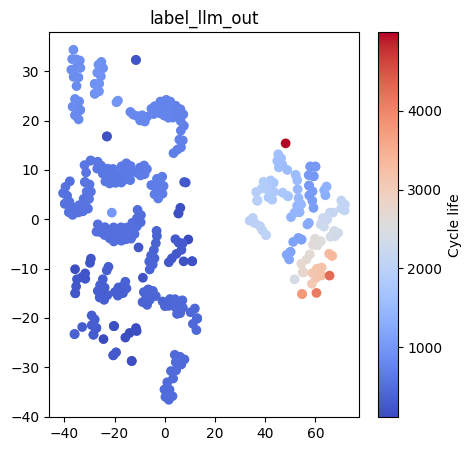

In [6]:
tsne = TSNE(n_components=2, random_state=2024)
transformed_features = tsne.fit_transform(total_avg_centers) # [N,2]
colormap =  matplotlib.colormaps['coolwarm']
norm = matplotlib.colors.Normalize(vmin=min(unique_labels), vmax=max(unique_labels))
total_colors = MinMaxScaler().fit_transform(np.array(unique_labels).reshape(-1, 1))
total_colors = total_colors.reshape(-1)

fig = plt.figure(figsize=(5,5))
plt.scatter(transformed_features[:,0], transformed_features[:,1], c=colormap(total_colors))
fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=colormap),label='Cycle life',ax=plt.gca())
plt.title('label_llm_out')
plt.show()

In [7]:
torch_total_avg_centers = torch.from_numpy(total_avg_centers)
D = torch_total_avg_centers.shape[-1]
distance_matric = torch.norm(torch_total_avg_centers.unsqueeze(1) - torch_total_avg_centers.unsqueeze(0), p=2, dim=-1) # [N, N]
print(torch.mean(distance_matric), torch.std(distance_matric), torch.median(distance_matric)) 

tensor(5.8286) tensor(2.3667) tensor(5.5053)
